In [85]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim



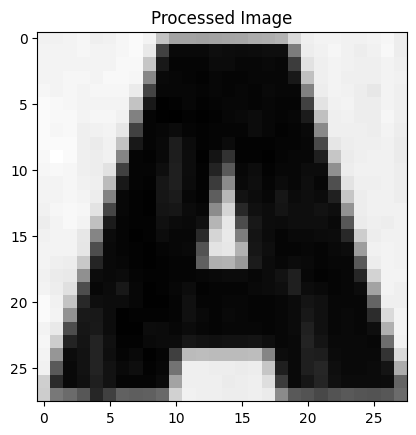

In [87]:

#image tweaking
transform = transforms.Compose([
    transforms.Grayscale(),  #grayscale
    transforms.Resize((28, 28)),  #resize
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#open a sample image (images from Chars74k dataset)
img_path = "./data/individual_chars/A/img011-00001.png"
image = Image.open(img_path)


processed_image = transform(image)

#display the transformation on sample image
plt.imshow(processed_image.squeeze(), cmap="gray")
plt.title("Processed Image")
plt.show()

In [89]:
dataset = datasets.ImageFolder(root="data/individual_chars", transform=transform)

trainloader = DataLoader(dataset, batch_size=64, shuffle=True)

dataiter = iter(trainloader)
images, labels = next(dataiter)
#check batch size
print(f"Image batch shape: {images.shape}")

Image batch shape: torch.Size([64, 1, 28, 28])


In [91]:

# Define classification network
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 62)  # 62 output nodes (A-Za-z + 0-9)
        self.LogSoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.LogSoftmax(self.fc3(x))
        return x

model = ClassificationNet()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [93]:
epochs = 20
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0], -1)  #flatten
        
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader)}")


Epoch 1/20 - Loss: 3.4114940383217554
Epoch 2/20 - Loss: 2.3022573595204627
Epoch 3/20 - Loss: 1.7743960569712742
Epoch 4/20 - Loss: 1.491755289972321
Epoch 5/20 - Loss: 1.3062921112233943
Epoch 6/20 - Loss: 1.1538067267945975
Epoch 7/20 - Loss: 1.0442932760419925
Epoch 8/20 - Loss: 0.9593864437962366
Epoch 9/20 - Loss: 0.8713432387872175
Epoch 10/20 - Loss: 0.8068497461720932
Epoch 11/20 - Loss: 0.7426889060942594
Epoch 12/20 - Loss: 0.6890013193296007
Epoch 13/20 - Loss: 0.6348307334687099
Epoch 14/20 - Loss: 0.5943723577113191
Epoch 15/20 - Loss: 0.5475200057522325
Epoch 16/20 - Loss: 0.5168863589113409
Epoch 17/20 - Loss: 0.47347380036164904
Epoch 18/20 - Loss: 0.44702371794822787
Epoch 19/20 - Loss: 0.4137385313914827
Epoch 20/20 - Loss: 0.3966420487431455


In [94]:
torch.save(model.state_dict(), "./trained models/captcha_model1.pth")

In [97]:
def predict_character(image_path, model):
    model.eval()  #set model to evaluation mode
    image = Image.open(image_path) #load sample image
    image = transform(image).view(1, -1)  #apply transforms

    with torch.no_grad(): #avoid gradient calculation
        output = model(image)
    
    prediction = torch.argmax(output, dim=1).item()  #.item() converts the result to an int
    return dataset.classes[prediction]  # Convert label index to character

#ouputs the folder name of the image
test_image = "data/individual_chars/e_lower/img041-00035.png"
predicted_char = predict_character(test_image, model)
print(f"Predicted Character: {predicted_char}")

Predicted Character: e_lower
